In [1]:
import torch.nn.utils as torch_utils
import torch.nn.functional as F
from torch.nn.init import xavier_normal_, xavier_uniform_
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init
import pandas as pd
import os 
import numpy as np

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Load the ECG data
ecgs = np.load(r'\\AMC_all_medians_precprocessed_np.np.npy')
ecgs_waveforms = ecgs[:100000, :, 20:-20]
distdr_medians = np.load(r'\\DISTDR_medians_precprocessed.np.npy')
ecgs_waveforms_2 = distdr_medians[:, :, 20:-20]

ecg_dataset = np.concatenate((ecgs_waveforms, ecgs_waveforms_2), axis=0)

ecg_dataset = ecg_dataset[:, np.newaxis, :, :, ]

# Define the split ratio
validation_split = 0.1
dataset_size = len(ecg_dataset)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

# Create two datasets: one for training and one for validation
train_dataset, val_dataset = random_split(ecg_dataset, [train_size, validation_size])

# Define batch size for both training and validation
batch_size = 32

# Create data loaders for training and validation
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

In [1]:
from VAEresnet_electrocar import* 
from utils import *
latent_dim = 32
beta = 100

red = 1
drop=0.0
vae = VAE(latent_dim, red).to(device)
vae_loss_fn = VAE_Loss(beta).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', cooldown = 2, factor=0.5, patience=4, verbose=True)

num_epochs = 5000
best_loss = float('inf') 
no_improvement_counter = 0
early_stopping_patience = 6

train_losses = []
val_losses = []

checkpoint_interval = 1 
checkpoint_counter = 1

best_loss = float('inf') 
no_improvement_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.train()  # Switch to training mode

for epoch in range(num_epochs):
    total_loss = 0.0
    total_kl_loss = 0.0
    vae.train()  # Switch to training mode
    for i, batch in enumerate(train_data_loader):
        inputs = batch.to(device).float()  
        optimizer.zero_grad()
        x_recon, z, mu, log_var  = vae(inputs)
        loss, _, kl_loss = vae_loss_fn(x_recon, inputs, mu, log_var)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 0.5)  # Choose an appropriate max_norm value
        optimizer.step()
        total_loss, total_kl_loss = update_total_losses_unsuper(
            total_loss, total_kl_loss, loss, kl_loss
        )

    avg_loss, avg_kl_loss = calculate_average_losses_unsuper(
        total_loss, total_kl_loss, train_data_loader
    )
    # Validation loop
    vae.eval()  # Switch to evaluation mode
    with torch.no_grad():
        total_val_loss = 0.0
        total_val_kl = 0.0
        for val_batch in val_data_loader:
            val_inputs = val_batch.to(device).float()
            val_x_recon, val_z, val_mu, val_log_var = vae(val_inputs)
            val_loss, _, val_kl_loss = vae_loss_fn(val_x_recon, val_inputs, val_mu, val_log_var)

            total_val_loss, total_val_kl = update_total_losses_unsuper(total_val_loss, total_val_kl, val_loss, val_kl_loss)
            avg_val_loss, avg_val_kl_loss = calculate_average_losses_unsuper(total_val_loss, total_val_kl, val_data_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Rec.T {avg_loss:.0f}, Rec.V: {avg_val_loss:.0f}, KL.T: {avg_kl_loss:.2f}, KL.V: {avg_val_kl_loss:.2f}")
        append_losses_unsuper(train_losses, val_losses, avg_loss, avg_val_loss)
        scheduler_on_loss = avg_val_loss
        scheduler.step(scheduler_on_loss)

        # Check for improvement and save checkpoint
        if scheduler_on_loss < best_loss:
            best_loss = scheduler_on_loss
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            if no_improvement_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

    vae.train()

#plot_losses_unsuper(train_losses, _)

# Save weights

In [7]:
final_model_dir = r"\\PRETRAIN"
os.makedirs(final_model_dir, exist_ok=True)

# Save the final model weights
final_model_path = os.path.join(final_model_dir, 'VAE2d-ECG weights.pt')
torch.save(vae.state_dict(), final_model_path)

# Load weights

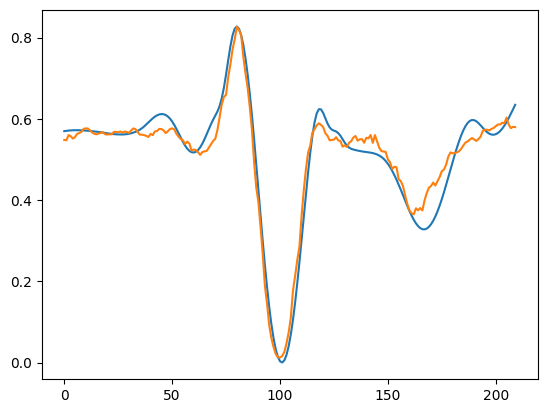

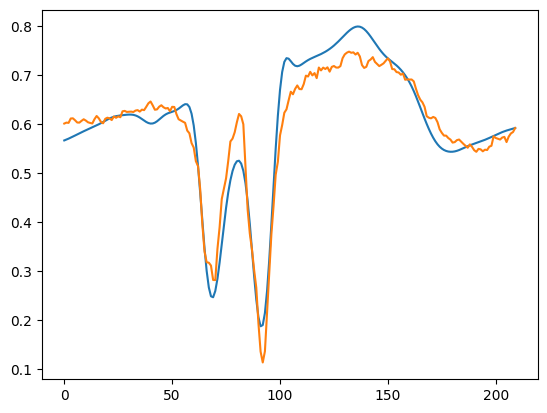

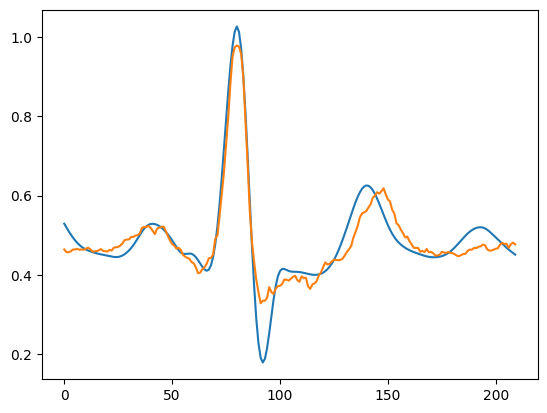

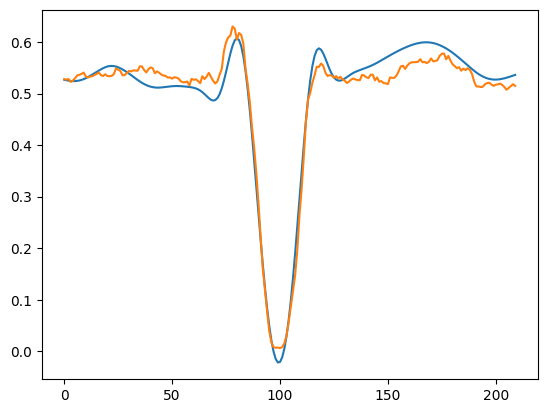

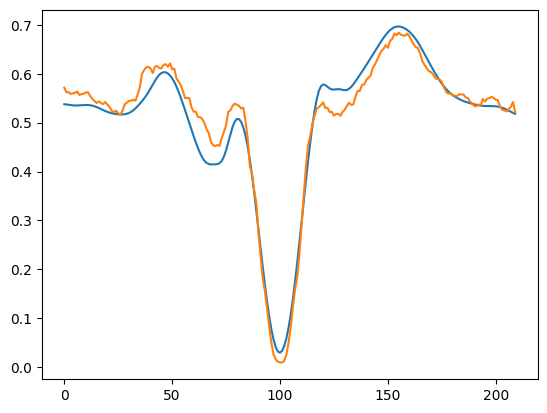

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

vae.eval()  # Set the model to evaluation mode

num_leads = 12  # Assuming you have 12 leads
all_original_signals = [[] for _ in range(num_leads)]
all_reconstructed_signals = [[] for _ in range(num_leads)]
correlations_overall = []
prd_overall = []
rmse_overall = []

# Set the number of epochs and batches
num_epochs = 1
batches_to_calculate = 25  # Choose the number of batches to calculate the metrics over

with torch.no_grad():  # No need to compute gradients during testing
    for epoch in range(num_epochs):
        for i, batch in enumerate(train_data_loader):
            if i >= batches_to_calculate:
                break  # Stop processing batches after reaching the desired number

            inputs = batch.float().to(device)

            # Forward pass (encode and decode)
            outputs, _, _, _ = vae(inputs)

            # Move the data back to the CPU for plotting (if needed)
            inputs_cpu = inputs.cpu()
            outputs_cpu = outputs.cpu()
            # Convert tensors to numpy arrays
            input_signals = inputs_cpu.numpy()
            reconstructed_signals = outputs_cpu.numpy()


            if i <= 4:
                plt.plot(input_signals[0, 0, 2, :])
                plt.plot(reconstructed_signals[0, 0, 2, :])
                plt.show()

            for lead in range(num_leads):
                all_original_signals[lead].append(input_signals[:, :, lead, :])
                all_reconstructed_signals[lead].append(reconstructed_signals[:, :, lead, :])

        # Calculate and print correlation coefficient, PRD, and RMSE for each lead
        for lead in range(num_leads):
            original_lead_signals = np.concatenate(all_original_signals[lead], axis=0)
            reconstructed_lead_signals = np.concatenate(all_reconstructed_signals[lead], axis=0)
            
            correlation_coefficient, _ = pearsonr(original_lead_signals.flatten(), reconstructed_lead_signals.flatten())
            prd = np.mean(np.abs(original_lead_signals - reconstructed_lead_signals) / np.maximum(np.abs(original_lead_signals), np.abs(reconstructed_lead_signals))) * 100
            rmse = np.sqrt(mean_squared_error(original_lead_signals.flatten(), reconstructed_lead_signals.flatten()))

            print(f"Epoch {epoch + 1}, Lead {lead + 1}:")
            print(f"Pearsoan Correlation Coefficient: {correlation_coefficient}")
            print(f"PRD: {prd}%")
            print(f"RMSE: {rmse}")

            correlations_overall.append(correlation_coefficient)
            prd_overall.append(prd)
            rmse_overall.append(rmse)

        # Clear accumulated signals after each epoch
        for lead in range(num_leads):
            all_original_signals[lead].clear()
            all_reconstructed_signals[lead].clear()
